# Analytics Zoo Recommendation Part 1
> Applying NCF on Movielens using Analytics Zoo library

- toc: true
- badges: true
- comments: true
- categories: [Movie, BigData, PySpark, AnalyticsZoo, NCF]
- author: "<a href='https://nbviewer.jupyter.org/github/intel-analytics/analytics-zoo/blob/master/apps/recommendation-ncf/ncf-explicit-feedback.ipynb'>Analytics Zoo</a>"
- image:

## Introduction

NCF Recommender with Explict Feedback

In this notebook we demostrate how to build a neural network recommendation system, Neural Collaborative Filtering(NCF) with explict feedback. We use Recommender API in Analytics Zoo to build a model, and use optimizer of BigDL to train the model. 

The system ([Recommendation systems: Principles, methods and evaluation](http://www.sciencedirect.com/science/article/pii/S1110866515000341)) normally prompts the user through the system interface to provide ratings for items in order to construct and improve the model. The accuracy of recommendation depends on the quantity of ratings provided by the user.  

NCF([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)) leverages a multi-layer perceptrons to learn the user–item interaction function, at the mean time, NCF can express and generalize matrix factorization under its framework. includeMF(Boolean) is provided for users to build a NCF with or without matrix factorization. 

Data: 
* The dataset we used is movielens-1M ([link](https://grouplens.org/datasets/movielens/1m/)), which contains 1 million ratings from 6000 users on 4000 movies.  There're 5 levels of rating. We will try classify each (user,movie) pair into 5 classes and evaluate the effect of algortithms using Mean Absolute Error.  
  
References: 
* A Keras implementation of Movie Recommendation([notebook](https://github.com/ririw/ririw.github.io/blob/master/assets/Recommending%20movies.ipynb)) from the [blog](http://blog.richardweiss.org/2016/09/25/movie-embeddings.html).
* Nerual Collaborative filtering ([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf))

Python interface:

```python
ncf = NeuralCF(user_count, item_count, class_num, user_embed=20, item_embed=20, hidden_layers=(40, 20, 10), include_mf=True, mf_embed=20)
```

- `user_count`: The number of users. Positive int.
- `item_count`: The number of classes. Positive int.
- `class_num`: The number of classes. Positive int.
- `user_embed`: Units of user embedding. Positive int. Default is 20.
- `item_embed`: itemEmbed Units of item embedding. Positive int. Default is 20.
- `hidden_layers`: Units of hidden layers for MLP. Tuple of positive int. Default is (40, 20, 10).
- `include_mf`: Whether to include Matrix Factorization. Boolean. Default is True.
- `mf_embed`: Units of matrix factorization embedding. Positive int. Default is 20.

## Installation

### Install Java 8

Run the command on the colaboratory file to install jdk 1.8

In [1]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Set jdk environment path which enables you to run Pyspark in your Colab environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


### Install Analytics Zoo from pip

You can add the following command on your colab file to install the analytics-zoo via pip easily:

In [2]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install analytics-zoo

     |████████████████████████████████| 158.9MB 44kB/s 
     |████████████████████████████████| 114.1MB 78kB/s 
     |████████████████████████████████| 215.6MB 63kB/s 
     |████████████████████████████████| 204kB 37.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.3-py2.py3-none-any.whl size=215964968 sha256=f00edffc8d08d9fa648fa23ecd0f5e6877c59541ad212b7e8720efc22cf5c0f3
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark


### Initialize context

Call init_nncontext() that will create a SparkContext with optimized performance configurations.

In [3]:
from zoo.common.nncontext import*

sc = init_nncontext()

Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar pyspark-shell 


Analytics Zoo provides three Recommenders, including Wide and Deep (WND) model, Neural network-based Collaborative Filtering (NCF) model and Session Recommender model. Easy-to-use Keras-Style defined models which provides compile and fit methods for training. Alternatively, they could be fed into NNFrames or BigDL Optimizer.

WND and NCF recommenders can handle either explict or implicit feedback, given corresponding features.

## Imports

In [7]:
from zoo.pipeline.api.keras.layers import *
from zoo.models.recommendation import UserItemFeature
from zoo.models.recommendation import NeuralCF
from zoo.common.nncontext import init_nncontext
import matplotlib
from sklearn import metrics
from operator import itemgetter
from bigdl.util.common import *

import os
import numpy as np

matplotlib.use('agg')
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Download movielens dataset

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-06-27 11:51:34--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  29.8MB/s    in 0.2s    

2021-06-27 11:51:35 (29.8 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


## Read the dataset

In [10]:
def read_data_sets(data_dir):
  rating_files = os.path.join(data_dir,"ratings.dat")
  rating_list = [i.strip().split("::") for i in open(rating_files,"r").readlines()]    
  movielens_data = np.array(rating_list).astype(int)
  return movielens_data 

def get_id_pairs(data_dir):
	movielens_data = read_data_sets(data_dir)
	return movielens_data[:, 0:2]

def get_id_ratings(data_dir):
	movielens_data = read_data_sets(data_dir)
	return movielens_data[:, 0:3]

In [ ]:
movielens_data = get_id_ratings("/content/ml-1m")

## Understand the data

In [13]:
min_user_id = np.min(movielens_data[:,0])
max_user_id = np.max(movielens_data[:,0])
min_movie_id = np.min(movielens_data[:,1])
max_movie_id = np.max(movielens_data[:,1])
rating_labels= np.unique(movielens_data[:,2])

print(movielens_data.shape)
print(min_user_id, max_user_id, min_movie_id, max_movie_id, rating_labels)

(1000209, 3)
1 6040 1 3952 [1 2 3 4 5]


Each record is in format of (userid, movieid, rating_score). UserIDs range between 1 and 6040. MovieIDs range between 1 and 3952. Ratings are made on a 5-star scale (whole-star ratings only). Counts of users and movies are recorded for later use.

## Transformation

Transform original data into RDD of sample. We use optimizer of BigDL directly to train the model, it requires data to be provided in format of RDD(Sample). A Sample is a BigDL data structure which can be constructed using 2 numpy arrays, feature and label respectively. The API interface is Sample.from_ndarray(feature, label) Here, labels are tranformed into zero-based since original labels start from 1.

In [14]:
def build_sample(user_id, item_id, rating):
    sample = Sample.from_ndarray(np.array([user_id, item_id]), np.array([rating]))
    return UserItemFeature(user_id, item_id, sample)

In [15]:
pairFeatureRdds = sc.parallelize(movielens_data).map(lambda x: build_sample(x[0], x[1], x[2]-1))
pairFeatureRdds.take(3)

## Split

Randomly split the data into train (80%) and validation (20%)

In [16]:
trainPairFeatureRdds, valPairFeatureRdds = pairFeatureRdds.randomSplit([0.8, 0.2], seed= 1)
valPairFeatureRdds.cache()

train_rdd= trainPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)
val_rdd= valPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)
val_rdd.persist()

PythonRDD[3] at RDD at PythonRDD.scala:53

In [17]:
train_rdd.count()

800491

In [18]:
train_rdd.take(3)

[Sample: features: [JTensor: storage: [1.000e+00 1.193e+03], shape: [2], float], labels: [JTensor: storage: [4.], shape: [1], float],
 Sample: features: [JTensor: storage: [  1. 914.], shape: [2], float], labels: [JTensor: storage: [2.], shape: [1], float],
 Sample: features: [JTensor: storage: [1.000e+00 3.408e+03], shape: [2], float], labels: [JTensor: storage: [3.], shape: [1], float]]

## Build model

In Analytics Zoo, it is simple to build NCF model by calling NeuralCF API. You need specify the user count, item count and class number according to your data, then add hidden layers as needed, you can also choose to include matrix factorization in the network. The model could be fed into an Optimizer of BigDL or NNClassifier of analytics-zoo. Please refer to the document for more details. In this example, we demostrate how to use optimizer of BigDL.

In [19]:
ncf = NeuralCF(user_count=max_user_id, 
               item_count=max_movie_id, 
               class_num=5, 
               hidden_layers=[20, 10], 
               include_mf = False)

creating: createZooKerasInput
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasEmbedding
creating: createZooKerasEmbedding
creating: createZooKerasFlatten
creating: createZooKerasFlatten
creating: createZooKerasMerge
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createZooNeuralCF


## Compile model

Compile model given specific optimizers, loss, as well as metrics for evaluation. Optimizer tries to minimize the loss of the neural net with respect to its weights/biases, over the training set. To create an Optimizer in BigDL, you want to at least specify arguments: model(a neural network model), criterion(the loss function), traing_rdd(training dataset) and batch size. Please refer to [ProgrammingGuide](https://bigdl-project.github.io/master/#ProgrammingGuide/optimization/) and [Optimizer](https://bigdl-project.github.io/master/#APIGuide/Optimizers/Optimizer/) for more details to create efficient optimizers.

In [20]:
ncf.compile(optimizer= "adam",
            loss= "sparse_categorical_crossentropy",
            metrics=['accuracy'])

creating: createAdam
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createZooKerasSparseCategoricalAccuracy


## Collect logs

You can leverage tensorboard to see the summaries.

In [21]:
tmp_log_dir = create_tmp_path()
ncf.set_tensorboard(tmp_log_dir, "training_ncf")

## Train the model

In [22]:
ncf.fit(train_rdd, 
        nb_epoch= 10, 
        batch_size= 8000, 
        validation_data=val_rdd)

## Prediction

Zoo models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted label.

In [23]:
results = ncf.predict(val_rdd)
results.take(5)

[array([0.00806034, 0.02006759, 0.18866627, 0.63047034, 0.15273541],
       dtype=float32),
 array([0.00254512, 0.00567304, 0.06865695, 0.46720853, 0.4559163 ],
       dtype=float32),
 array([0.00535633, 0.02252354, 0.12654975, 0.4168996 , 0.42867082],
       dtype=float32),
 array([0.00396674, 0.01450644, 0.12073953, 0.60501534, 0.255772  ],
       dtype=float32),
 array([0.00394357, 0.01327773, 0.14935595, 0.6658978 , 0.16752498],
       dtype=float32)]

In [24]:
results_class = ncf.predict_class(val_rdd)
results_class.take(5)

[4, 4, 5, 4, 4]

In Analytics Zoo, Recommender has provied 3 unique APIs to predict user-item pairs and make recommendations for users or items given candidates.

### Predict for user item pairs

In [25]:
userItemPairPrediction = ncf.predict_user_item_pair(valPairFeatureRdds)
for result in userItemPairPrediction.take(5): print(result)

UserItemPrediction [user_id: 1, item_id: 661, prediction: 4, probability: 0.630470335483551]
UserItemPrediction [user_id: 1, item_id: 2804, prediction: 4, probability: 0.46720853447914124]
UserItemPrediction [user_id: 1, item_id: 1035, prediction: 5, probability: 0.42867082357406616]
UserItemPrediction [user_id: 1, item_id: 2687, prediction: 4, probability: 0.6050153374671936]
UserItemPrediction [user_id: 1, item_id: 2321, prediction: 4, probability: 0.665897786617279]


### Recommend 3 items for each user given candidates in the feature RDDs

In [26]:
userRecs = ncf.recommend_for_user(valPairFeatureRdds, 3)
for result in userRecs.take(5): print(result)

UserItemPrediction [user_id: 4904, item_id: 750, prediction: 5, probability: 0.8882462382316589]
UserItemPrediction [user_id: 4904, item_id: 1198, prediction: 5, probability: 0.8594017028808594]
UserItemPrediction [user_id: 4904, item_id: 912, prediction: 5, probability: 0.8534067869186401]
UserItemPrediction [user_id: 1084, item_id: 50, prediction: 5, probability: 0.7139193415641785]
UserItemPrediction [user_id: 1084, item_id: 2324, prediction: 5, probability: 0.6326656937599182]


### Recommend 3 users for each item given candidates in the feature RDDs

In [27]:
itemRecs = ncf.recommend_for_item(valPairFeatureRdds, 3)
for result in itemRecs.take(5): print(result)

UserItemPrediction [user_id: 2909, item_id: 384, prediction: 4, probability: 0.40346845984458923]
UserItemPrediction [user_id: 1409, item_id: 384, prediction: 3, probability: 0.4329181909561157]
UserItemPrediction [user_id: 4789, item_id: 384, prediction: 3, probability: 0.41791829466819763]
UserItemPrediction [user_id: 1940, item_id: 1084, prediction: 5, probability: 0.8245269060134888]
UserItemPrediction [user_id: 2497, item_id: 1084, prediction: 5, probability: 0.7757750749588013]


## Evaluation

Plot the train and validation loss curves

Text(0.5, 1.0, 'loss')

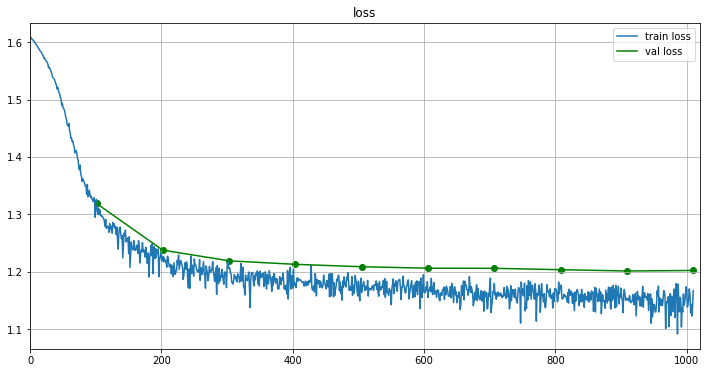

In [28]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
train_loss = np.array(ncf.get_train_summary("Loss"))
val_loss = np.array(ncf.get_validation_summary("Loss"))
#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.figure(figsize = (12,6))
plt.plot(train_loss[:,0],train_loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='val loss',color='green')
plt.scatter(val_loss[:,0],val_loss[:,1],color='green')
plt.legend();
plt.xlim(0,train_loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

Plot accuracy

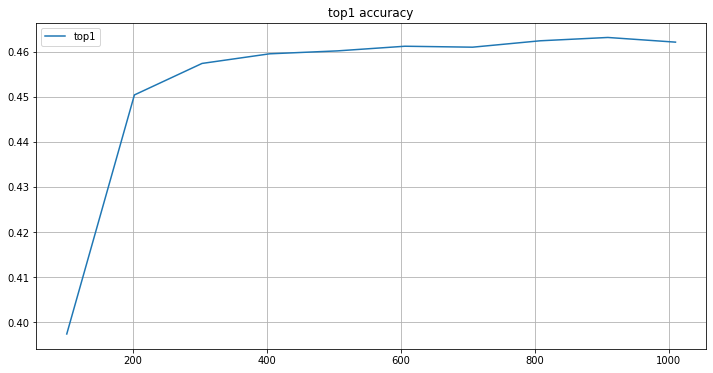

In [29]:
plt.figure(figsize = (12,6))
top1 = np.array(ncf.get_validation_summary("Top1Accuracy"))
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.title("top1 accuracy")
plt.grid(True)
plt.legend();